In [199]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import sys
import os
import glob
import numpy as np
sys.path.append("../../Code")
import settings as s
import images as im
import files 
import utils
import preprocessing as pre

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
hosts = pd.read_csv('../2/len_lang_restrict_hosts.csv', index_col=0)
guests = pd.read_csv('../2/len_lang_restrict_guests.csv', index_col=0)
reviews = pd.read_csv('../2/len_lang_restrict_reviews.csv', index_col=0)
listings = pd.read_csv('../2/len_lang_restrict_listings.csv', index_col=0)

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [191]:
print("Hosts: ", len(hosts))
print("Overall Guests: ", len(reviews['reviewer_id'].unique()))
print("Retrieved Guests: ", len(guests))
print("Reviews: ", len(reviews))
print("Listings: ", len(listings))

Hosts:  11339
Overall Guests:  211498
Retrieved Guests:  93961
Reviews:  225484
Listings:  11337


In [192]:
hosts_loc = pd.read_csv('hosts_with_people.csv', index_col=0)

In [193]:
hosts['num_of_people_in_pic'] = hosts.join(hosts_loc[['id','num_of_people_in_pic']].astype(str).set_index('id'), on='id')['num_of_people_in_pic']

In [194]:
utils.create_value_counts_table(hosts, 'num_of_people_in_pic', 'people_in_pic')

,people_in_pic,counts,%
0,1.0,5935,52.34
1,0.0,3680,32.45
2,2.0,1383,12.20
3,3.0,226,1.99
4,4.0,55,0.49
5,nan,43,0.38
6,5.0,7,0.06
7,7.0,4,0.04
8,6.0,3,0.03
9,NaN,2,0.02


In [195]:
def reduce_by_people_in_image(hosts, listings, reviews, guests):   
    
    # Reduced Hosts
    new_hosts = hosts[hosts['num_of_people_in_pic'].astype(float) == 1]
    print("Revised number of Hosts: %d (decreased %.2f %%)" % (len(new_hosts), utils.get_decreased_percent(new_hosts, hosts)))

    # Reduced Listings
    new_listings = listings[listings['host_id'].isin(set(new_hosts['id'].astype(str)))]
    print("Revised number of Listings: %d (decreased %.2f %%)" % (len(new_listings), utils.get_decreased_percent(new_listings, listings)))

    # Reduced Reviews
    new_reviews = reviews[reviews['recipient_id'].isin(set(new_hosts['id'].astype(str)))]
    print("Revised number of Reviews: %d (decreased %.2f %%)" % (len(new_reviews), utils.get_decreased_percent(new_reviews, reviews)))

    # Reduced Overall Guests
    overall_guests = reviews['reviewer_id'].unique()
    new_overall_guests = new_reviews['reviewer_id'].unique()
    print("Revised number of Overall Guests: %d (decreased %.2f %%)" % (len(new_overall_guests), utils.get_decreased_percent(new_overall_guests, overall_guests)))

    # Reduced Retrieved Guests
    new_retrieved_guests = guests[guests['id'].isin(new_overall_guests)]
    print("Revised number of Retrieved Guests: %d (decreased %.2f %%)" % (len(new_retrieved_guests), utils.get_decreased_percent(new_retrieved_guests, guests)))

    return (new_hosts, new_listings, new_reviews, new_overall_guests, new_retrieved_guests)

In [196]:
new_hosts, new_listings, new_reviews, new_overall_guests, new_retrieved_guests = reduce_by_people_in_image(hosts, listings, reviews, guests)

Revised number of Hosts: 5935 (decreased 47.66 %)
Revised number of Listings: 5935 (decreased 47.65 %)
Revised number of Reviews: 109784 (decreased 51.31 %)
Revised number of Overall Guests: 105427 (decreased 50.15 %)
Revised number of Retrieved Guests: 47249 (decreased 49.71 %)


# Number of Reviews 

In [198]:
host_review_count = new_reviews.groupby('recipient_id').count()[['id']].rename(columns={'id': 'num_of_reviews'})
count_table = utils.create_value_counts_table(host_review_count, 'num_of_reviews', 'num_of_guest_reviews')
count_table.head(10)

,num_of_guest_reviews,counts,%
0,1,982,16.55
1,2,643,10.83
2,3,443,7.46
3,4,358,6.03
4,5,281,4.73
5,6,236,3.98
6,7,211,3.56
7,8,176,2.97
8,9,149,2.51
9,10,121,2.04


   num_of_guest_reviews  counts      %
0                     1     982  16.55
1                     2     643  10.83
2                     3     443   7.46
3                     4     358   6.03
4                     5     281   4.73
5                     6     236   3.98
6                     7     211   3.56
7                     8     176   2.97
8                     9     149   2.51
9                    10     121   2.04


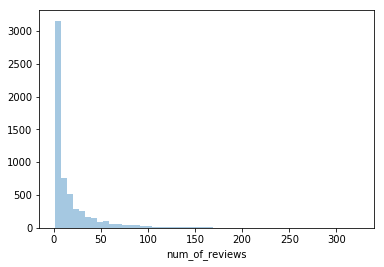

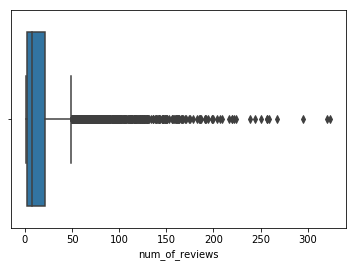

Average: 18.497725358045493
Min: 1
Max: 324
Variance: 908.1350832842861
Std deviation: 30.135279711399495


In [200]:
pre.show_reviews_per_person_dist(host_review_count, 'recipient_id')

In [203]:
pre.build_exclusion_table(host_review_count, new_reviews, new_listings, 1, 6)

,Exclusion(By # of reviews per host),Pre-exclusion,> 1,> 2,> 3,> 4,> 5
0,Hosts,5935,4953 (83.45%),4310 (72.62%),3867 (65.16%),3509 (59.12%),3228 (54.39%)
1,Reviews,109784,108802 (99.11%),107516 (97.93%),106187 (96.72%),104755 (95.42%),103350 (94.14%)
2,Guests,105427,104503 (99.12%),103316 (98.00%),102080 (96.83%),100735 (95.55%),99413 (94.30%)
3,Listings,5935,4953 (83.45%),4310 (72.62%),3867 (65.16%),3509 (59.12%),3228 (54.39%)


# Extra

In [32]:
hosts_left_df['num_of_people'] = im.get_num_of_people(os.path.join("..",s.DATA_DIR, 'host_imgs'), hosts_left_df['id'])

In [33]:
hosts_left_df.to_csv('hosts_left_done_2.csv')

In [36]:
for i in range(3, 20):
    hosts_left_df = pd.read_csv('hosts_left_done_' + str(i) +'.csv')
    hosts_left_df['num_of_people'] = im.get_num_of_people(os.path.join("..",s.DATA_DIR, 'host_imgs'), hosts_left_df['id'])
    hosts_left_df.to_csv('hosts_left_done_' + str(i) +'.csv')